In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)


In [18]:
"""
    A simple feedforward neural network for image classification tasks, with an adjustable dropout rate 
    for regularization. The model consists of two fully connected layers with ReLU activation and dropout 
    applied after the first layer.

    Architecture:
    - Input Layer: Takes input images reshaped into a vector of 784 features (28*28 pixels).
    - Hidden Layer: A fully connected layer that transforms the 784 input features into 64 hidden units, 
      followed by ReLU activation and a dropout layer to prevent overfitting.
    - Output Layer: Maps the 64 hidden units to 10 output classes, suitable for classification tasks 
      with 10 categories, such as the MNIST dataset.

    Dropout is applied after the hidden layer to reduce overfitting by randomly setting a proportion 
    of the neurons to zero during training. The dropout rate can be adjusted via the `dropout_rate` 
    parameter in the constructor.

    Forward Pass:
    - The input tensor is first flattened from a 2D image (batch_size, 1, 28, 28) to a 1D vector (batch_size, 784).
    - The input passes through the hidden layer with ReLU activation and dropout.
    - The final output layer provides a tensor of raw scores for each class.
"""


class SimpleNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)  # Reduced hidden units
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [19]:
def compute_hessian_and_sharpness(model, data, target, criterion, epsilon=1e-4):
    model.zero_grad()
    loss = criterion(model(data), target)
    
    # Get gradients of loss with respect to model parameters
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    
    # Choose a small subset of parameters to compute Hessian to save time
    grad_params_flatten = torch.cat([g.view(-1) for g in grad_params[:1]])  # Only considering the first layer
    
    hessian = torch.zeros((grad_params_flatten.size(0), grad_params_flatten.size(0)), device=data.device)
    
    # Compute Hessian
    for idx in range(grad_params_flatten.size(0)):
        grad2_params = torch.autograd.grad(grad_params_flatten[idx], model.parameters(), retain_graph=True)
        grad2_params_flatten = torch.cat([g.contiguous().view(-1) for g in grad2_params[:1]])  # Only first layer
        hessian[idx] = grad2_params_flatten

    hessian_norm = torch.norm(hessian, p=2).item()
    sharpness = hessian_norm * epsilon**2 / (2 * (1 + loss.item()))
    
    # Clear gradients to break the reference cycle and avoid memory leak
    model.zero_grad()
    
    return sharpness

In [20]:
def train_model(model, trainloader, criterion, optimizer, epochs=2):  # Reduced epochs to save time
    model.train()
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [21]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return loss, accuracy


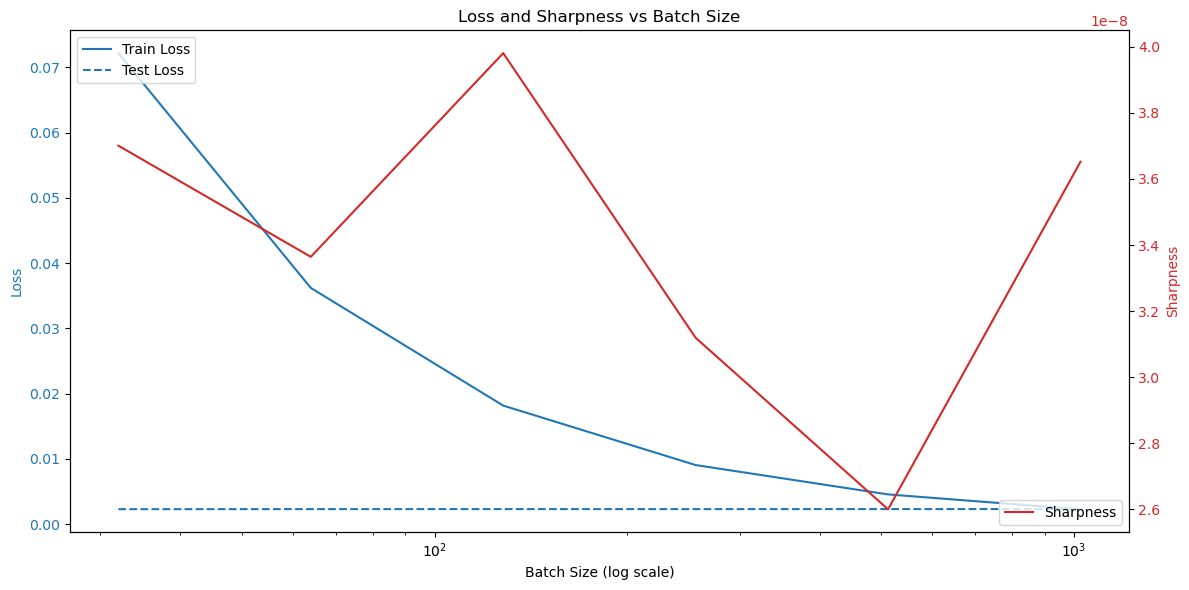

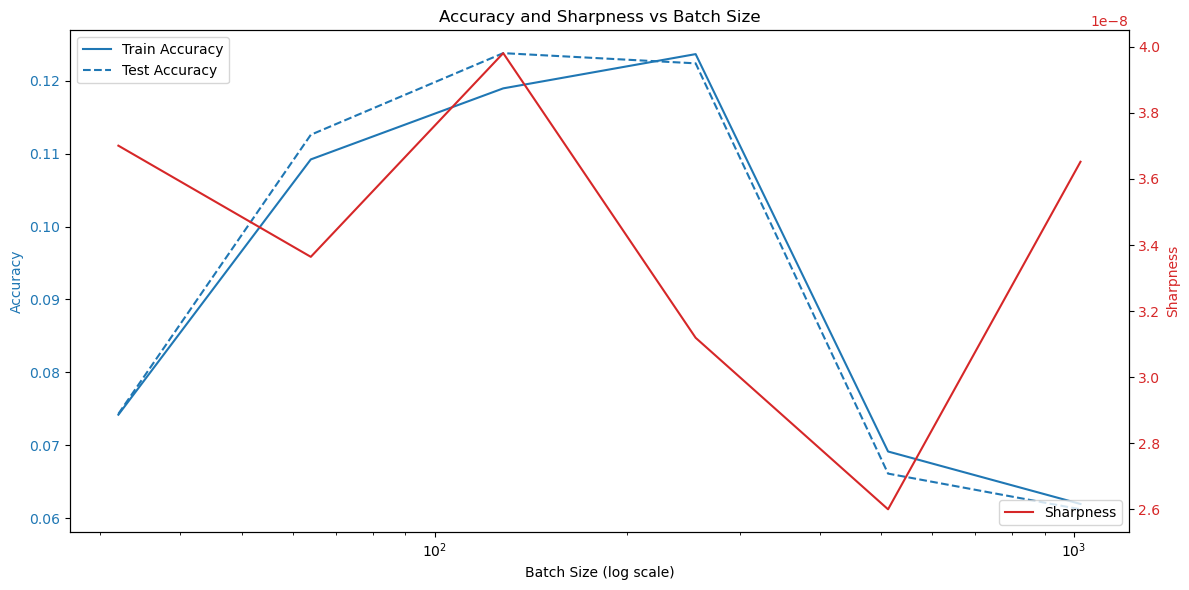

In [22]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
learning_rate = 1e-10
dropout_rate = 0.2
optimizer_choice = 'Adam'
results = {'batch_size': [], 'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'sharpness': []}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch_size in batch_sizes:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Create model, loss function, and optimizer
    model = SimpleNN(dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, trainloader, criterion, optimizer)

    # Evaluate the model
    train_loss, train_acc = evaluate_model(model, trainloader, criterion)
    test_loss, test_acc = evaluate_model(model, testloader, criterion)
    
    # Compute sharpness
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        sharpness = compute_hessian_and_sharpness(model, inputs, labels, criterion)
        break

    # Store results
    results['batch_size'].append(batch_size)
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)
    results['sharpness'].append(sharpness)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot loss and sharpness on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Batch Size (log scale)')
ax1.set_ylabel('Loss', color=color)
ax1.plot(results['batch_size'], results['train_loss'], label='Train Loss', color=color)
ax1.plot(results['batch_size'], results['test_loss'], label='Test Loss', color='tab:blue', linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.legend(loc='upper left')

# Create a secondary y-axis for sharpness
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Sharpness', color=color)  
ax2.plot(results['batch_size'], results['sharpness'], label='Sharpness', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right')

plt.title('Loss and Sharpness vs Batch Size')
fig.tight_layout()  
plt.show()

# Plotting accuracy vs sharpness
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Batch Size (log scale)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(results['batch_size'], results['train_acc'], label='Train Accuracy', color=color)
ax1.plot(results['batch_size'], results['test_acc'], label='Test Accuracy', color='tab:blue', linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.legend(loc='upper left')

# Create a secondary y-axis for sharpness
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Sharpness', color=color)  
ax2.plot(results['batch_size'], results['sharpness'], label='Sharpness', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right')

plt.title('Accuracy and Sharpness vs Batch Size')
fig.tight_layout()  
plt.show()